Dear passengers, please remain seated with your seatbelts securely fastened as we continue to go more deeper with some AI stuff. We apologize for the delay and appreciate your cooperation during this time.

*Section e*

In this notebook i will address the solution of sections e to g.

Let's start by importing the relevant libraries and load the data and preproccess it.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LSTM, Linear, Dropout, BatchNorm1d
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, Callback
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from torchmetrics import Accuracy

from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch

In the cell below, i loaded the tran and val data and preproccess it as we did before.

In [5]:
train_data = pd.read_csv('/home/janz/model/data/train.csv')
unlabeled_folder_path = '/home/janz/model/data/unlabeled/unlabeled/'
data = {}
for index, row in train_data.iterrows():
    id_ = row['id']
    csv_filename = os.path.join(unlabeled_folder_path, f"{id_}.csv")
    df = pd.read_csv(csv_filename)
    userid = row['userid']
    sensor = row['sensor']
    body_part = row['body_part']
    side = row['side']
    sequence_length = row['sequence_length']
    activity = row['activity']
    data[id_] = {
        'dataframe': df,
        'userid': userid,
        'sensor': sensor,
        'body_part': body_part,
        'side': side,
        'sequence_length': sequence_length,
        'activity': activity
    }

for id_, info in data.items():
    df = data[id_]['dataframe']
    if 'measurement type' in info['dataframe'].columns:
        data[id_]['dataframe'].drop(df[df['measurement type'] != 'acceleration [m/s/s]'].index, inplace=True)
for id_, info in data.items():
    df = data[id_]['dataframe']
    if 'measurement type' not in info['dataframe'].columns:
        df.rename(columns={'x [m]': 'x', 'y [m]': 'y', 'z [m]': 'z'}, inplace=True)
        df[['x', 'y', 'z']] *= 9.8

In the cell below, i loaded the test data and preproccess it, and splitted the tran data to 80% train and 20% test.

In [6]:
unlabeled_files = os.listdir(unlabeled_folder_path)
unlabeled_data = {}
for filename in unlabeled_files:
    id_ = int(filename.split('.')[0])
    if id_ not in data.keys():
        csv_filename = os.path.join(unlabeled_folder_path, filename)
        df = pd.read_csv(csv_filename)
        unlabeled_data[id_] = {'dataframe': df}
for id_, info in unlabeled_data.items():
    df = unlabeled_data[id_]['dataframe']
    if 'measurement type' in info['dataframe'].columns:
        unlabeled_data[id_]['dataframe'].drop(df[df['measurement type'] != 'acceleration [m/s/s]'].index, inplace=True)
for id_, info in unlabeled_data.items():
    df = unlabeled_data[id_]['dataframe']
    if 'measurement type' not in info['dataframe'].columns:
        df.rename(columns={'x [m]': 'x', 'y [m]': 'y', 'z [m]': 'z'}, inplace=True)
        df[['x', 'y', 'z']] *= 9.8
for id_, info in unlabeled_data.items():
    if 'measurement type' in info['dataframe']:
        info['dataframe'] = info['dataframe'].drop(columns=['measurement type'])

for id_, info in unlabeled_data.items():
    df = info['dataframe']
    if df.isnull().values.any():
        for col in df.columns:
            for i in range(len(df)):
                if pd.isnull(df.loc[i, col]):
                    if i == 0:
                        df.loc[i, col] = df.loc[i + 1, col]
                    elif i == len(df) - 1:
                        df.loc[i, col] = df.loc[i - 1, col]
                    else:
                        df.loc[i, col] = (df.loc[i - 1, col] + df.loc[i + 1, col]) / 2


type1_data = [data[id_] for id_ in data if 'measurement type' in data[id_]['dataframe'].columns]
type2_data = [data[id_] for id_ in data if 'measurement type' not in data[id_]['dataframe'].columns]

type1_train = []
type1_val = []
for activity in train_data['activity'].unique():
    activity_data = [d for d in type1_data if d['activity'] == activity]
    train_activity_data, val_activity_data = train_test_split(activity_data, test_size=0.2, random_state=42)
    type1_train.extend(train_activity_data)
    type1_val.extend(val_activity_data)

type2_train = []
type2_val = []
for activity in train_data['activity'].unique():
    activity_data = [d for d in type2_data if d['activity'] == activity]
    if len(activity_data) > 1:
        train_activity_data, val_activity_data = train_test_split(activity_data, test_size=0.2, random_state=42)
        type2_train.extend(train_activity_data)
        type2_val.extend(val_activity_data)

train_set = type1_train + type2_train
val_set = type1_val + type2_val

for sample in train_set:
    if 'measurement type' in sample['dataframe']:
        sample['dataframe'] = sample['dataframe'].drop(columns=['measurement type'])
for sample in val_set:
    if 'measurement type' in sample['dataframe']:
        sample['dataframe'] = sample['dataframe'].drop(columns=['measurement type'])

for key in unlabeled_data.keys():
    unlabeled_data[key] = unlabeled_data[key]['dataframe']

unlabeled_data = dict(sorted(unlabeled_data.items()))

In the cell below, we seperated the data to x (data frames) and y (target labels // id's for test data), also made the label encoder to transform the string labels to numeric ones.

In [7]:
X_train = []
y_train = []
for sample in train_set:
    X_train.append(sample['dataframe'])
    y_train.append(sample['activity'])

# Extract features and labels for validation set
X_val = []
y_val = []
for sample in val_set:
    X_val.append(sample['dataframe'])
    y_val.append(sample['activity'])

X_test = []
test_ids = []
for id in unlabeled_data.keys():
    X_test.append(unlabeled_data[id])
    test_ids.append(id)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels (activities)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

y_train_tensor = torch.tensor(y_train_encoded)
y_val_tensor = torch.tensor(y_val_encoded)
test_ids_tensor = torch.tensor(test_ids)

The code below, is a general padding algorithm which is simple and used most times when handling different sequence length data data:

This code segment achieves sequence length standardization by padding the input sequences with zeros to a fixed length of 4000. Padding ensures that all sequences have the same length, regardless of their original length, thereby enabling consistent input dimensions for the LSTM model (and the masked autoencoder). Zeros are commonly used for padding as they are neutral values that do not introduce any additional information into the sequences. This padding strategy maintains the integrity of the original data while providing a uniform format suitable for processing by the LSTM network.

In [ ]:
fixed_length = 4000

# Assuming X_train_lstm and X_val_lstm are lists of sequences
X_train_padded = pad_sequence([torch.FloatTensor(seq.values[:fixed_length]) for seq in X_train], batch_first=True)
X_val_padded = pad_sequence([torch.FloatTensor(seq.values[:fixed_length]) for seq in X_val], batch_first=True)
X_test_padded = pad_sequence([torch.FloatTensor(seq.values[:fixed_length]) for seq in X_test], batch_first=True)

The code below, is part of section f and g, it is an improvement to the padding problem:

This updated code segment refines the sequence padding process by introducing a new function, pad_with_original_data, which pads the sequences with portions of the original data rather than zeros. The function iteratively extends each sequence to the target length by appending segments from the original sequence, maintaining the integrity of the underlying data. The choice of padding position, either 'first' or 'last', allows flexibility in preserving the temporal context of the sequences. By leveraging portions of the original data for padding, this approach minimizes the introduction of artificial information and better reflects the characteristics of the input sequences, potentially enhancing the performance of the LSTM model.

In [8]:
def pad_with_original_data(seq, target_length, pad_position='last'):
    """
    Pad the sequence with a portion of the original data to reach the target length.
    """
  
    while(len(seq) < target_length):
        # print(len(seq))
        original_length = len(seq)
        padding_length = target_length - original_length
        if pad_position == 'first':
            padding = seq[:padding_length]  # Pad with the first portion of the sequence
            seq += padding
            seq = np.concatenate((seq, padding), axis=0)
        elif pad_position == 'last':
            padding = seq[-padding_length:]  # Pad with the last portion of the sequence
            seq = np.concatenate((seq, padding), axis=0)
    return torch.tensor(seq, dtype=torch.float)  # Convert sequence to tensor

fixed_length = 4000

# Assuming X_train_lstm and X_val_lstm are lists of sequences
X_train_padded = pad_sequence([pad_with_original_data(seq.values, fixed_length, pad_position='last') for seq in X_train], batch_first=True)
X_val_padded = pad_sequence([pad_with_original_data(seq.values, fixed_length, pad_position='last') for seq in X_val], batch_first=True)
X_test_padded = pad_sequence([pad_with_original_data(seq.values, fixed_length, pad_position='last') for seq in X_test], batch_first=True)


Data is done, loaded, preproccessed amd padded, next step is building and implementing the choice we made in section e, which is one of the self-supervised tasks we introduced in section 1c.
we have picked masked autoencoder for the following reason:

Choosing the Masked Autoencoder approach over the Denoising Autoencoder for self-supervised learning presents several advantages in certain contexts. By opting for the Masked Autoencoder (Task 2), i have specifically targeting the task of predicting missing or masked values in the input data. This choice is particularly beneficial when dealing with datasets where the information may be incomplete or partially obscured. The Masked Autoencoder enables the model to learn representations that capture the underlying structure of the data while effectively handling missing information. This can be advantageous in our scenario because our data is a time-series data, where predicting missing values accurately is crucial for downstream tasks or analysis. Additionally, the Masked Autoencoder approach offers more flexibility in handling various types of missing data patterns (can be related duo to the fact that data sequences are not the same) and can be tailored to specific application domains, making it a versatile choice for self-supervised learning tasks.

How i did that:

let's start by the layers of the model and the hyperparameters: In this Masked Autoencoder architecture, we've designed two main components: the encoder and the decoder. The encoder takes the input data and compresses it into a lower-dimensional representation, capturing essential features. This compressed representation is then passed through the decoder, which aims to reconstruct the original input data. We've incorporated Rectified Linear Unit (ReLU) activation functions in both the encoder and decoder layers to introduce non-linearity, allowing the model to learn complex patterns in the data. Additionally, we've implemented a masking function that randomly zeros out a small portion of the input data to simulate missing or masked values. This setup enables the model to learn how to handle incomplete or corrupted data effectively, enhancing its robustness and generalization capabilities. The chosen hyperparameters, such as the hidden size, learning rate, and batch size, have been carefully selected to ensure efficient training of the model. Overall, this architecture and approach show promise for addressing missing data imputation tasks effectively.

Important note, in this code, and general in all the code in this notebook and the model notebook, you are going to see a commented rows of codes and not explanation, which will represent the work i did for improvement number 1 in section f, more on that will be explained deeply in f and g section in the end of this notebook. but just be aware that the commented lines are lines of code before the improvements.

The hyperparameters, including the hidden size, learning rate, and batch size, are carefully chosen values that dictate the architecture and training process of the Masked Autoencoder model.
(Different hyper parameters was experienced to decide what best fit the model).
number of epochs 200 was the point were i think the model converges.
input size is 3 because the dataframes had 3 columns (x, y, z).
learning rate 0.001 was the best lr for all the models in this project, since it helped all the models converge in a "reasonable" way.
And a batch size and hidden size were chosen by picking the best values of them by experience them with different values.

In [9]:
input_size = 3
hidden_size = 32 #32
learning_rate = 0.001
num_epoch = 200
batch_size = 32

class MaskedAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            # nn.Linear(2*hidden_size, 4*hidden_size),
            # nn.ReLU(),
            nn.Linear(2*hidden_size, 3),  # Add another hidden layer
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 2*hidden_size),
            nn.ReLU(),
            # nn.Linear(4*hidden_size, 2*hidden_size),
            # nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

    # def __init__(self, input_size, hidden_size):
    #     super(MaskedAutoencoder, self).__init__()
    #     self.encoder = nn.Sequential(
    #         nn.Linear(input_size, hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, hidden_size // 2),  # Reduce hidden size
    #         nn.ReLU()
    #     )
    #     self.decoder = nn.Sequential(
    #         nn.Linear(hidden_size // 2, hidden_size),  # Use the same reduced hidden size
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, input_size)
    #     )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def mask_data(data):
    mask = torch.rand_like(data) < 0.05
    masked_data = data.clone()
    masked_data[mask] = 0
    return masked_data

This code block initializes the device to either CUDA (GPU) if available or CPU, preprocesses the training, validation, and test data by applying a masking function to each sequence, converts the masked sequences into PyTorch tensors, creates datasets using TensorDataset combining masked and original sequences, and prepares DataLoader objects for training, validation, and test sets for subsequent model training and evaluation.

Note: that here we gave y labels as the main padded data, where the model (masked autoencoder) have to pridect the missing values with the original values, and not with the y taget labels of the data.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing and DataLoader for training data
X_train_masked = [mask_data(seq) for seq in X_train_padded]
X_train_masked_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_train_masked])
X_train_padded_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_train_padded])
train_dataset = TensorDataset(X_train_masked_tensor, X_train_padded_tensor)

# Preprocessing and DataLoader for validation data
X_val_masked = [mask_data(seq) for seq in X_val_padded]
X_val_masked_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_val_masked])
X_val_padded_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_val_padded])
val_dataset = TensorDataset(X_val_masked_tensor, X_val_padded_tensor)

# Preprocessing and DataLoader for test data
X_test_masked = [mask_data(seq) for seq in X_test_padded]
X_test_masked_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_test_masked])
X_test_padded_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_test_padded])
test_dataset = TensorDataset(X_test_masked_tensor, X_test_padded_tensor)

/tmp/ipykernel_43438/2159656355.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_masked_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_train_masked])
/tmp/ipykernel_43438/2159656355.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_padded_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_train_padded])
/tmp/ipykernel_43438/2159656355.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_masked_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq i

create DataLoader objects for the training, validation, and test datasets, specifying the batch size and setting shuffle to False, indicating that the data should not be shuffled during loading (there is no need to shuffle the train set here, since the model is trying to predict the input data and not the target labels, this makes shuffling neglectable and with no sence in this model). 

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Here, we initialize the Masked Autoencoder model using the specified input size and hidden size. We then move the model to the specified device. Next, we define the Mean Squared Error (MSE) loss function, commonly used for regression tasks like autoencoder reconstruction. Finally, we set up the Adam optimizer to update the model parameters during training, with the specified learning rate.

In [12]:
# Initialize the Masked Autoencoder model, loss function, and optimizer
model = MaskedAutoencoder(input_size, hidden_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Here is simply a training loop for the Masked Autoencoder model.

In [13]:
# Training loop
for epoch in range(num_epoch):
    model.train() 
    train_loss = 0.0
    
    for batch in train_loader:
        inputs = batch[0].to(device)
        target = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation
    model.eval() 
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            target = batch[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, target)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    # Print the epoghhch and loss
    print(f'Epoch [{epoch+1}/{num_epoch}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/200], Train Loss: 4.5960, Val Loss: 4.5046
Epoch [2/200], Train Loss: 2.0387, Val Loss: 7.1848
Epoch [3/200], Train Loss: 1.9618, Val Loss: 4.7797
Epoch [4/200], Train Loss: 1.8847, Val Loss: 5.0322
Epoch [5/200], Train Loss: 1.8553, Val Loss: 5.4613
Epoch [6/200], Train Loss: 1.8133, Val Loss: 5.4383
Epoch [7/200], Train Loss: 1.7877, Val Loss: 5.3723
Epoch [8/200], Train Loss: 1.7641, Val Loss: 5.7528
Epoch [9/200], Train Loss: 1.7481, Val Loss: 6.2866
Epoch [10/200], Train Loss: 1.7351, Val Loss: 6.6226
Epoch [11/200], Train Loss: 1.7232, Val Loss: 7.1889
Epoch [12/200], Train Loss: 1.7086, Val Loss: 7.7560
Epoch [13/200], Train Loss: 1.6936, Val Loss: 8.2518
Epoch [14/200], Train Loss: 1.6863, Val Loss: 8.1560
Epoch [15/200], Train Loss: 1.6813, Val Loss: 7.2454
Epoch [16/200], Train Loss: 1.6628, Val Loss: 7.1159
Epoch [17/200], Train Loss: 1.6516, Val Loss: 6.8752
Epoch [18/200], Train Loss: 1.6475, Val Loss: 6.9160
Epoch [19/200], Train Loss: 1.6455, Val Loss: 6.5021
Ep

This code extracts features from the trained Masked Autoencoder model for the training, validation, and test sets. It first initializes empty lists to store the extracted features. Then, it sets the model to evaluation mode to disable gradient computation. Features are extracted batch-wise from each dataset using the model's encoder, and the resulting features are appended to the corresponding lists. Finally, the extracted features are concatenated along the appropriate axis to create numpy arrays for each dataset.

Using encoder features instead of the output allows for capturing higher-level abstract representations of the input data, facilitating more efficient and effective processing in downstream tasks.

In [14]:
# Initialize lists to store features
train_features = []
val_features = []
test_features = []

# Set model to evaluation mode
model.eval()

# Extract features for training set
with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(device)
        features = model.encoder(inputs)
        train_features.append(features.cpu().numpy())

# Extract features for validation set
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0].to(device)
        features = model.encoder(inputs)
        val_features.append(features.cpu().numpy())

# Extract features for test set
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        features = model.encoder(inputs)
        test_features.append(features.cpu().numpy())

# Concatenate features into numpy arrays
train_features = np.concatenate(train_features, axis=0)
val_features = np.concatenate(val_features, axis=0)
test_features = np.concatenate(test_features, axis=0)


train_data = (train_features, y_train_tensor)
val_data = (val_features, y_val_tensor)
test_data = (test_features, test_ids_tensor)

Ok, masked autooencoder finished, new era, where we will test again how the pretrained model will affect the results of the previous ml dl models.

Let's start first with the ml model (random foret) and test it out.

Note: again the models were tested out first with the code before the improvements, and then tested out again with the improvements, at the end of the notebook i compared between the two results.

Same code, same explanation..

But the main difference here, is contrary to what we did before, here we are extracting statistical features from the feature extracted from the masked autoencoder data and not the original data, which is the main reason for this notebook. But it's the same process as before.

In [15]:
def extract_features_from_accelerometer_data(df):
    features = []
    
    # Mean
    mean_values = df.mean()
    features.extend(mean_values.tolist())
    
    # Standard Deviation
    std_values = df.std()
    features.extend(std_values.tolist())
    
    # Root Mean Square (RMS)
    rms_value = np.sqrt(np.mean(df**2))
    features.extend(rms_value.tolist())
    
    # Skewness
    skewness_values = df.apply(skew)
    features.extend(skewness_values.tolist())
    
    # Kurtosis
    kurtosis_values = df.apply(kurtosis)
    features.extend(kurtosis_values.tolist())
    
    # Peak-to-Peak Amplitude
    peak_to_peak_values = df.apply(lambda x: x.max() - x.min())
    features.extend(peak_to_peak_values.tolist())
    
    # Autocorrelation Coefficients
    autocorr = df.apply(lambda x: x.autocorr())
    features.append(autocorr.mean())
    features.append(autocorr.std())
    
    # Fast Fourier Transform (FFT) Coefficients
    fft_coeffs = np.abs(np.fft.fft(df))
    features.extend(np.mean(fft_coeffs, axis=0).tolist())
    features.extend(np.std(fft_coeffs, axis=0).tolist())
    
    # # Entropy
    # entropy_values = df.apply(lambda x: entropy(np.histogram(x[~np.isnan(x)], bins='auto')[0]))
    # features.extend(entropy_values.tolist())


    
    # Additional Statistical Features i have to test (include improvment for the previous)
    # Median
    median_values = df.median()
    features.extend(median_values.tolist())
    
    # Interquartile Range (IQR)
    iqr_values = df.quantile(0.75) - df.quantile(0.25)
    features.extend(iqr_values.tolist())
    
    # # Minimum
    # min_values = df.min()
    # # features.extend(min_values.tolist())
    
    # # Maximum
    # max_values = df.max()
    # # features.extend(max_values.tolist())
    
    # # Range
    # range_values = max_values - min_values
    # features.extend(range_values.tolist())
    
    # Variance
    variance_values = df.var()
    features.extend(variance_values.tolist())
    
    # Coefficient of Variation (CV)
    cv_values = std_values / mean_values
    features.extend(cv_values.tolist())
    
    # Root Mean Square Deviation (RMSD)
    rmsd_values = np.sqrt(np.mean((df - mean_values)**2))
    # features.append(np.nan_to_num(rmsd_values))
    for value in np.nan_to_num(rmsd_values):
        features.append(value)
    
    # Mean Absolute Deviation (MAD)
    med_abs_dev_values = np.median(np.abs(df - np.median(df)))
    # features.extend(med_abs_dev_values.tolist())
    features.append(np.nan_to_num(med_abs_dev_values))
    
    # # Sum
    # sum_values = df.sum()
    # features.extend(sum_values.tolist())

    
    # Concatenate features into a single feature vector
    feature_vector = np.array(features).flatten()

    return feature_vector

In [16]:
# It is an important step to extract features, so let's write some elegant code explanation:
def extract_features(dataset):
    
    dataset_features = dataset[0]
    dataset_target_labels = dataset[1]

    X = []  # Feature vectors
    y = []  # Labels

    for sample_id in range(len(dataset_features)):
        df = pd.DataFrame(dataset_features[sample_id]) # columns=["x", "y", "z"] is deleted since we have feature extractions data
        # Extract relevant features from the accelerometer measurements
        features = extract_features_from_accelerometer_data(df)

        # Append features to X
        X.append(features)

        # Append label to y
        y.append(dataset_target_labels[sample_id])

    return X, y

# Extract features from the training set
X_train_r_cnn, y_train_r_cnn = extract_features(train_data)

# Extract features from the validation set
X_val_r_cnn, y_val_r_cnn = extract_features(val_data)

X_test_r_cnn, test_ids_r_cnn = extract_features(test_data)

Random Forest

Same logic, same code, let's calculate the random forest results but this time with the features extracted from the statistical features which extracted from the data the has features extracted from the extracted features that had been extracted by the extraction features.. hhh what did i say? lol foget about it and just move on, this project is making me mad (mad or rms)

In [17]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

def flatten(arr):
    flat_arr = []
    for item in arr:
        if isinstance(item, np.ndarray):
            flat_arr.extend(flatten(item))
        else:
            flat_arr.append(item)
    return flat_arr

X_train_flat = [flatten(sample) if isinstance(sample, np.ndarray) else sample for sample in X_train_r_cnn]
X_val_flat = [flatten(sample) if isinstance(sample, np.ndarray) else sample for sample in X_val_r_cnn]

# Convert X_train_flat to a PyTorch tensor and move it to GPU
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32).cuda()
X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32).cuda()

y_train_encoded = y_train_r_cnn
y_val_encoded = y_val_r_cnn

# Convert y_train_encoded to a PyTorch tensor
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).cuda()
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long).cuda()

# Train the Random Forest model
rf_classifier.fit(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy())

# Predict labels for the training set
train_predictions_rf = rf_classifier.predict(X_train_tensor.cpu().numpy())

# Calculate accuracy score on the training set
train_accuracy_rf = accuracy_score(y_train_tensor.cpu().numpy(), train_predictions_rf)

# Predict labels for the validation set
val_predictions_rf = rf_classifier.predict(X_val_tensor.cpu().numpy())

# Calculate accuracy score on the validation set
val_accuracy_rf = accuracy_score(y_val_tensor.cpu().numpy(), val_predictions_rf)

print("Train Accuracy (Random Forest):", train_accuracy_rf)
print("Validation Accuracy (Random Forest):", val_accuracy_rf)

Train Accuracy (Random Forest): 1.0
Validation Accuracy (Random Forest): 0.9344197138314785


Test features are first converted to a NumPy array and then to a PyTorch tensor, which is moved to the GPU for computation. Using the trained Random Forest classifier, class probabilities are predicted for the test data. These probabilities are then converted back to activity names using the label encoder's inverse transformation.....

In [ ]:
# Convert test features to a NumPy array and then to a tensor
X_test_np = np.array(X_test_r_cnn, dtype=np.float32)
X_test_tensor = torch.tensor(X_test_np).cuda()

# Make predictions using the trained Random Forest classifier
test_probabilities_numpy = rf_classifier.predict_proba(X_test_tensor.cpu().numpy())

# Convert the class probabilities to activity names
activity_names = label_encoder.inverse_transform(rf_classifier.classes_)

# Organize the probabilities into a DataFrame
probabilities_df = pd.DataFrame(test_probabilities_numpy, index=test_ids_r_cnn, columns=activity_names)

# Extract numerical values from tensor objects in the index
probabilities_df.index = [int(idx.item()) for idx in probabilities_df.index]

# Save the predictions to a CSV file
probabilities_df.index.name = "sample_id"
probabilities_df.to_csv('/home/janz/model/predictions_randomforest.csv')

CNN

Moving on to 1d cnn model which we did before, but this time as explained, we will feed him the statistical features which was extracted from the masked autoencoder feature extractions.. pleaase don't do it again, ok

Data preperation as usuall..

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the mapping between activity names and encoded numerical values
activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_r_cnn, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_r_cnn, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded).to(device)
y_val_tensor = torch.tensor(y_val_encoded).to(device)

# Create DataLoader
train_data_cnn = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data_cnn, batch_size=64, shuffle=True)
val_data_cnn = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data_cnn, batch_size=64)

Same cnn model architecture, and same input size (same statistics), and same everything, same layers, same learning rate, same num classes.. ok we know, stop.

In [51]:
# Set random seed for PyTorch's random number generator
torch.manual_seed(42)

# Define hyperparameters
input_size = 42  # Size of feature vector
num_classes = 18  # Number of unique activities
num_epochs = 100
learning_rate = 0.001 # 0.001

class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # self.batch_norm1 = nn.BatchNorm1d(32)  # Batch normalization after conv1
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.batch_norm2 = nn.BatchNorm1d(64)  # Batch normalization after conv2
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.batch_norm3 = nn.BatchNorm1d(128)  # Batch normalization after conv2
        # self.relu3 = nn.ReLU()
        # self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        self.fc = nn.Linear(64 * (input_size // 4), num_classes)  # Adjusted number of neurons
        # self.fc1 = nn.Linear(128 * (input_size // 8), 256)  # Added fully connected layer
        # self.fc2 = nn.Linear(256, num_classes)  # Output layer
        
        # self.dropout = nn.Dropout(0.5)  # Adding dropout

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # x = self.conv3(x)
        # x = self.batch_norm3(x)
        # x = self.relu3(x)
        # x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        # x = self.dropout(x)  # Applying dropout
        x = self.fc(x)
        # x = torch.flatten(x, 1)
        # x = F.relu(self.fc1(x))  # Apply ReLU after the first fully connected layer
        # x = self.dropout(x)  # Applying dropout
        # x = self.fc2(x)
        return x

# Initialize the model
model = CNN1D(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    

same

In [52]:
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
train_accuracies = []  # List to store training accuracies
val_accuracies = []    # List to store validation accuracies

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Record training loss for this epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)  # Record training accuracy for this epoch
    
    # Compute validation loss and accuracy
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)  # Record validation loss for this epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)  # Record validation accuracy for this epoch
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}")


Epoch [1/100], Training Loss: 2.0109, Validation Loss: 1.5647, Training Accuracy: 37.59%, Validation Accuracy: 46.96%
Epoch [2/100], Training Loss: 1.4390, Validation Loss: 1.3534, Training Accuracy: 48.54%, Validation Accuracy: 51.12%
Epoch [3/100], Training Loss: 1.2843, Validation Loss: 1.2428, Training Accuracy: 53.67%, Validation Accuracy: 56.14%
Epoch [4/100], Training Loss: 1.2026, Validation Loss: 1.1789, Training Accuracy: 56.15%, Validation Accuracy: 57.83%
Epoch [5/100], Training Loss: 1.1422, Validation Loss: 1.1439, Training Accuracy: 58.23%, Validation Accuracy: 58.62%
Epoch [6/100], Training Loss: 1.0959, Validation Loss: 1.1162, Training Accuracy: 60.00%, Validation Accuracy: 59.82%
Epoch [7/100], Training Loss: 1.0553, Validation Loss: 1.0409, Training Accuracy: 61.46%, Validation Accuracy: 63.01%
Epoch [8/100], Training Loss: 1.0231, Validation Loss: 1.0533, Training Accuracy: 62.82%, Validation Accuracy: 62.39%
Epoch [9/100], Training Loss: 1.0007, Validation Loss: 1

same

In [53]:
# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

Accuracy on training set: 83.12%


same, can you stop saying same? ok

In [54]:
# Evaluation on validation data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation set: {(100 * correct / total):.2f}%")

Accuracy on validation set: 79.50%


identical, :-/ really?

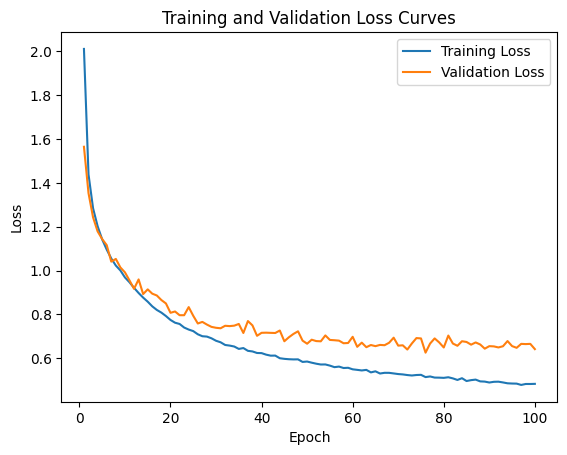

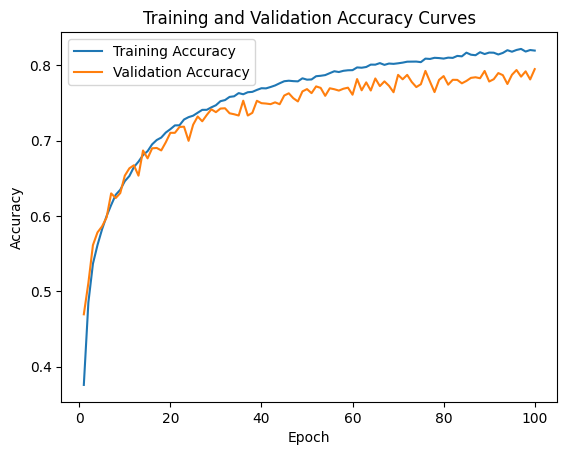

In [55]:
# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy Curves
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I didn't do the visualize predictions as i did before, because i saw no relevant for this matter of comparing between the previous model and pretrained model.

And of cours the classification report.

In [56]:
# Calculate and print other relevant metrics (precision, recall, F1-score) using sklearn.metrics
from sklearn.metrics import classification_report

# Predictions on training data
train_predicted = model(X_train_tensor)
train_predicted_labels = torch.argmax(train_predicted, axis=1).cpu().numpy()
train_true_labels = torch.tensor(y_train_encoded).cpu().numpy()

# Predictions on validation data
val_predicted = model(X_val_tensor)
val_predicted_labels = torch.argmax(val_predicted, axis=1).cpu().numpy()
val_true_labels = torch.tensor(y_val_encoded).cpu().numpy()

# Classification report for training data
print("Classification Report for Training Data:")
print(classification_report(train_true_labels, train_predicted_labels, target_names=activity_mapping.keys()))

# Classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(val_true_labels, val_predicted_labels, target_names=activity_mapping.keys()))


Classification Report for Training Data:
                               precision    recall  f1-score   support

               brushing_teeth       0.93      0.92      0.92      1147
                         idle       0.90      0.92      0.91      2139
           preparing_sandwich       0.91      0.93      0.92      1792
                 reading_book       0.95      0.91      0.93      2005
                  stairs_down       0.98      1.00      0.99       924
                    stairs_up       1.00      0.91      0.95      1004
                       typing       0.98      0.94      0.96       959
                  using_phone       0.83      0.74      0.78      3450
         using_remote_control       0.92      0.91      0.91      2041
               walking_freely       0.71      0.79      0.75      3661
       walking_holding_a_tray       0.89      0.81      0.85      3552
         walking_with_handbag       0.70      0.70      0.70      3607
walking_with_hands_in_pockets      

TEST

In [ ]:
# Convert test features to a PyTorch tensor and move it to GPU
X_test_tensor = torch.tensor(X_test_r_cnn, dtype=torch.float32).cuda()

In [ ]:
# Predict labels for test data
# model.eval()
# predictions = []
# with torch.no_grad():
#     outputs = model(X_test_tensor)
#     _, predicted = torch.max(outputs, 1)
#     predictions = predicted.tolist()

# Create DataFrame with activity probabilities
activities = label_encoder.classes_
activity_probs = model(X_test_tensor).softmax(dim=1).cpu().tolist()
df_results = pd.DataFrame(activity_probs, index=test_ids_r_cnn, columns=activities)
df_results.index.name = 'sample_id'

df_results.index = [int(idx.item()) for idx in df_results.index]

# Sort rows by DataFrame ID
# df_results.sort_index(inplace=True)

# Save DataFrame to CSV file
df_results.to_csv('/home/janz/model/predictions_cnn.csv')

LSTM

Now, when it comes to the LSTM, it still the same code, but with different logic, here we feed the model with the features that was extracted before but without the statistical extractions was we did before to the last models, because the lstm can handle the ffeatured extracted as sequences and to learn from them, while random forest and cnn are unalbe to do that.

In [60]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Hyperparameters
input_size = 3
hidden_size = 32
num_layers = 2
num_classes = len(label_encoder.classes_)
learning_rate = 0.001
num_epochs = 100
batch_size = 128

# Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

#         # self.fc = nn.Linear(hidden_size, num_classes)
#         self.fc1 = nn.Linear(hidden_size, 64)
#         self.fc2 = nn.Linear(64, num_classes)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.lstm(x, (h0, c0))

#         # out = self.fc(out[:, -1, :])
#         out = self.fc1(out[:, -1, :])
#         out = self.fc2(out)
#         return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # self.fc = nn.Linear(hidden_size, num_classes)
        self.fc1 = nn.Linear(hidden_size, 256)  # Increase number of neurons
        self.fc2 = nn.Linear(256, 128)  # Add another fully connected layer
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

        # self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))

        # out = self.fc(out[:, -1, :])

        out = out[:, -1, :]  # Extract the output of the last time step
        out = self.relu(self.fc1(out))  # Apply activation
        out = self.relu(self.fc2(out))  # Apply activation
        out = self.fc3(out)
        return out


identical

In [61]:
# Define a custom dataset class
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)

# Create DataLoader for training and validation
train_dataset = SensorDataset(train_data[0], train_data[1])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SensorDataset(val_data[0], val_data[1])
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

identical

In [62]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/tmp/ipykernel_43438/2250252420.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Epoch 1/100, Train Loss: 2.2918, Train Accuracy: 0.2055, Val Loss: 2.0265, Val Accuracy: 0.2657
Epoch 2/100, Train Loss: 1.9354, Train Accuracy: 0.2795, Val Loss: 1.9442, Val Accuracy: 0.2862
Epoch 3/100, Train Loss: 1.8092, Train Accuracy: 0.3100, Val Loss: 1.8137, Val Accuracy: 0.3095
Epoch 4/100, Train Loss: 1.7130, Train Accuracy: 0.3344, Val Loss: 1.6511, Val Accuracy: 0.3528
Epoch 5/100, Train Loss: 1.7089, Train Accuracy: 0.3349, Val Loss: 1.6445, Val Accuracy: 0.3486
Epoch 6/100, Train Loss: 1.6118, Train Accuracy: 0.3639, Val Loss: 1.5567, Val Accuracy: 0.3864
Epoch 7/100, Train Loss: 1.5419, Train Accuracy: 0.3889, Val Loss: 1.5086, Val Accuracy: 0.3989
Epoch 8/100, Train Loss: 1.5259, Train Accuracy: 0.4046, Val Loss: 1.5150, Val Accuracy: 0.4020
Epoch 9/100, Train Loss: 1.4413, Train Accuracy: 0.4295, Val Loss: 1.4429, Val Accuracy: 0.4293
Epoch 10/100, Train Loss: 1.3816, Train Accuracy: 0.4508, Val Loss: 1.3851, Val Accuracy: 0.4495
Epoch 11/100, Train Loss: 1.3216, Train

identical

In [63]:
# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

/tmp/ipykernel_43438/2250252420.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Accuracy on training set: 81.51%
Accuracy on training set: 76.62%


identical, can you stop with identical?

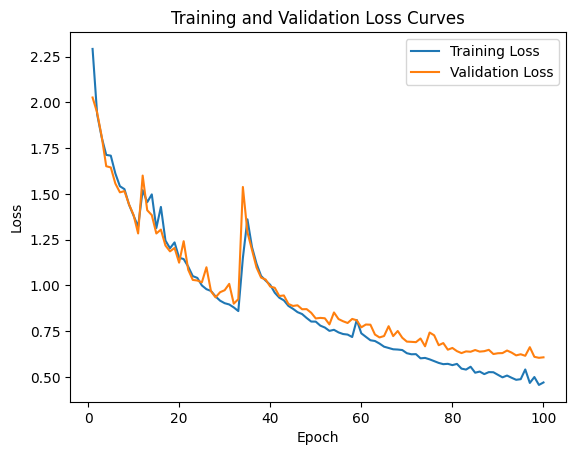

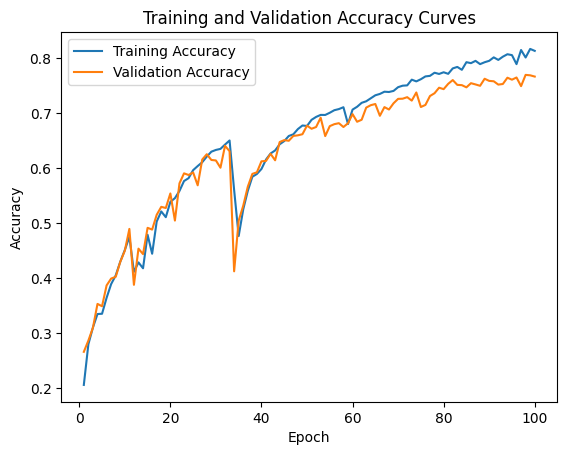

In [65]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

equivalent

In [66]:
from sklearn.metrics import classification_report

# Predictions on training data
train_predicted = []
train_true_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_predicted.extend(torch.argmax(outputs, axis=1).tolist())
        train_true_labels.extend(labels.tolist())

# Predictions on validation data
val_predicted = []
val_true_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_predicted.extend(torch.argmax(outputs, axis=1).tolist())
        val_true_labels.extend(labels.tolist())

# Classification report for training data
print("Classification Report for Training Data:")
print(classification_report(train_true_labels, train_predicted, target_names=activity_mapping.keys()))

# Classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(val_true_labels, val_predicted, target_names=activity_mapping.keys()))


/tmp/ipykernel_43438/2250252420.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Classification Report for Training Data:
                               precision    recall  f1-score   support

               brushing_teeth       0.97      0.91      0.94      1147
                         idle       0.85      0.89      0.87      2139
           preparing_sandwich       0.83      0.88      0.85      1792
                 reading_book       0.91      0.89      0.90      2005
                  stairs_down       0.99      1.00      1.00       924
                    stairs_up       0.99      0.98      0.99      1004
                       typing       0.89      0.89      0.89       959
                  using_phone       0.83      0.64      0.72      3450
         using_remote_control       0.86      0.89      0.87      2041
               walking_freely       0.73      0.78      0.75      3661
       walking_holding_a_tray       0.83      0.88      0.85      3552
         walking_with_handbag       0.72      0.65      0.68      3607
walking_with_hands_in_pockets      

TEST

In this code snippet, a testing loop is implemented to evaluate the trained model on the test dataset. The test dataset is loaded into a DataLoader with a specified batch size. The model is then set to evaluation mode using `model.eval()` to disable dropout and batch normalization layers. Predicted probabilities for each sample in the test dataset are obtained using a forward pass through the model. These probabilities are then converted to numpy arrays and stored in a list called `probabilities`. After iterating through all batches in the test loader, the sample IDs and corresponding predicted probabilities are combined into a DataFrame called `result_df`. Finally, this DataFrame is saved to a CSV file named 'predictions_lstm.csv' without including the index.

In [67]:
# Testing loop
test_dataset = SensorDataset(test_data[0], test_data[1])
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [68]:
# Get predicted probabilities for test data
model.eval()
probabilities = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Prepare data for CSV
sample_ids = test_data[1]
activity_probabilities = pd.DataFrame(probabilities, columns=label_encoder.classes_)

# Combine sample IDs and probabilities
result_df = pd.DataFrame({'sample_id': sample_ids})
result_df = pd.concat([result_df, activity_probabilities], axis=1)

# Write probabilities to CSV
result_df.to_csv('/home/janz/model/predictions_lstm.csv', index=False)


/tmp/ipykernel_43438/2250252420.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


WoW, The project code is done, can i cry now? no

let's now explain section f+g.

*Sections F and G*

Where the model is performing well:

Utilizing two distinct methodologies, LSTM (Long Short-Term Memory) and Random Forest, the model demonstrates noteworthy efficacy. However, the preference leans towards LSTM, primarily due to its inherent suitability for time series data analysis. While CNN (Convolutional Neural Network) models are not inherently tailored for time series data, both LSTM and Random Forest exhibit competence in classification tasks. Notably, Random Forest exhibits adeptness in handling the statistical features extracted from the dataset.

Why the model is performing well:

The effectiveness of the LSTM model can be attributed to its inherent capability to handle sequential data, aligning closely with the nature of time series datasets. LSTM's architecture, designed to capture temporal dependencies and long-range dependencies in sequences, renders it particularly adept for such tasks. Although training an LSTM model is computationally intensive and time-consuming, necessitating meticulous hyperparameter tuning and analysis, its proficiency in capturing the intricate patterns within time series data justifies the investment of computational resources.

Now, let's describe what were the implementations of improvements and what the improvements we suggested:

1. The improvement steps involve a systematic process of experimenting with different model architectures, varying the number of layers, neurons, activation functions, and other hyperparameters to optimize the performance of the models. This process aims to find the best combination of model settings that maximizes performance metrics such as accuracy, precision, recall, or F1-score.

The architectures may have different numbers of layers, hidden units, and activation functions. By trying out various architectures, we can identify which one is best suited for the specific task at hand, considering factors such as the nature of the input data and the complexity of the problem (like trying two fully connected layers and not one... (commented codes)).

Next, different hyperparameters are tuned to further enhance model performance. These hyperparameters may include learning rate, batch size, dropout rate, optimizer type, and regularization techniques. Through a process of trial and error, each hyperparameter is adjusted, and the model's performance is evaluated on a validation set. This iterative process continues until the model converges to the optimal set of hyperparameters that yields the highest performance on the validation set.

Overall, the improvement steps involve a thorough exploration of different model architectures and hyperparameters to iteratively improve the model's performance until satisfactory results are achieved.

2. In the improvement step where two different padding algorithms were tried, the focus was on addressing the challenge of handling time series data with varying lengths. Padding is a crucial decision when dealing with such data, as it directly impacts how the model processes sequences of different lengths. 

The first padding algorithm utilized zero-padding, where sequences are padded with zeros to match a fixed target length. While simpler and computationally more efficient, zero-padding may introduce noise or bias into the sequences, especially if the actual data has a non-zero mean or contains meaningful information in zero-valued entries. However, zero-padding ensures that all sequences are of equal length, facilitating batch processing and enabling the model to learn more efficiently.

The second padding algorithm involved padding sequences with a portion of the original data to reach a fixed target length. This method aims to preserve as much original information as possible by padding either the beginning or the end of sequences with segments from the original data. It ensures that the model has access to the complete temporal context of each sequence, potentially leading to better performance in capturing long-term dependencies.

By experimenting with these two padding algorithms, the goal was to determine which approach better suited the characteristics of the data and the requirements of the model. This improvement step highlights the importance of thoughtful decision-making in preprocessing steps, as the choice of padding algorithm can significantly impact the model's ability to effectively learn from time series data.

3. While feature selection improvement might be a important one, i want rather to speaak about The utilization of powerful GPU and computational resources (Because i see the project is too big to be an assignment for such short time, we are speaking ai algorithms not implementing regular classification machine learning model, and not just one deep learning models, rather twoooo). These resources offer accelerated training times, enabling us (students) to iterate more swiftly through the code, explore diverse model architectures, and conduct extensive hyperparameter optimization. But, for my misery, i couldn't accomplish this improvment, it took me nearly 3 days just trying to be able to use the university clusters, while wasting a lot of time trying to run the code in colab and kaggle and get out of memmory everytime. But lastly i am happy with what i did in this project.

While we were able to implement the first two improvements and see the results, we will compare them now and compare the usage of the pretrain model.

That's why you now have to go and see the "results" word file on amazon prime.

Dear passengers, we've landed safely (with no errors). We appreciate your cooperation throughout the flight and hope you enjoyed your journey with us. Please remain seated until the aircraft has reached the gate, and the seatbelt sign has been turned off.